In [ ]:
# %cd ../stu_dataset

/home/daniel/Dev/ms_proj/stu_dataset


/home/daniel/Dev/ms_proj/cosmos-reason1/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# %pip install open3d

In [2]:
from pathlib import Path
import torch

import cv2
import numpy as np
import open3d as o3d
from PIL import Image
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset


# Normalize intensities
def normalize_intensities(intensities):
    return np.clip(intensities / 255, 0, 1)


# Filter points that are inside a given polygon
def filter_points_in_polygon(image_points, polygon, corresponding_3d_points):
    path = Path(polygon)
    inside = path.contains_points(image_points)
    return image_points[inside], corresponding_3d_points[inside], inside


# Save colored point cloud as a PCD file
def save_colored_pcd(points, colors, output_pcd_file):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(output_pcd_file, pcd)
    print(f"Saved colored PCD at: {output_pcd_file}")


def load_point_cloud(scan_path):
    scan = np.fromfile(scan_path, dtype=np.float32)
    scan = scan.reshape(
        (-1, 4)
    )  # The point cloud data is stored in a Nx4 format (x, y, z, intensity)
    points = scan[:, :3]  # Extracting the (x, y, z) coordinates
    intensities = scan[:, 3:]  # Extracting the (x, y, z) coordinates
    return (points, intensities)


def load_labels(label_path):
    labels = np.fromfile(label_path, dtype=np.uint32).astype(np.int32)
    semantic_label = labels & 0xFFFF
    instance_label = labels >> 16
    return semantic_label, instance_label


def project_points_pinhole(points, camera_matrix, dist_coeffs):
    if points.size == 0:
        return (np.array([]), np.array([]))
    rvec = np.zeros((3, 1))
    tvec = np.zeros((3, 1))
    image_points, _ = cv2.projectPoints(
        points.reshape(-1, 1, 3), rvec, tvec, camera_matrix, dist_coeffs
    )
    image_points = image_points.reshape(-1, 2)
    return image_points


def transform_points(points, T):
    points_hom = np.hstack((points, np.ones((points.shape[0], 1))))
    points_transformed = (T @ points_hom.T).T[:, :3]
    return points_transformed


def get_image_labels(
    base_path,
    idx,
    image_width,
    image_height,
    camera_matrix,
    dist_coeffs,
    translation,
    yaw,
    pitch,
    roll,
):
    label_file = base_path / f"labels/{idx:06d}.label"
    point_file = base_path / f"velodyne/{idx:06d}.bin"
    # 
    label_file = Path(label_file)
    labels, _ = load_labels(label_file)
    points, _ = load_point_cloud(point_file)
    # 
    labels[(labels != 2) & (labels != 0)] = 1
    # 
    # Construct the transformation matrix
    r = R.from_euler("ZYX", [yaw, pitch, roll])
    rotation_matrix = r.as_matrix()
    transformation_inv = np.eye(4)
    transformation_inv[:3, :3] = rotation_matrix.T
    transformation_inv[:3, 3] = -np.dot(rotation_matrix.T, translation)
    # 
    # Transform points into the camera frame
    points_transformed = transform_points(points, transformation_inv)
    # 
    # Use only points in front of the camera (z > 0)
    valid_indices = points_transformed[:, 2] > 0
    points_camera_valid = points_transformed[valid_indices]
    valid_labels = labels[valid_indices]
    # 
    # Project to image plane
    image_points = project_points_pinhole(
        points_camera_valid, camera_matrix, dist_coeffs
    )
    # 
    # Convert projected points to integer coordinates
    pts_int = image_points.astype(int)
    # 
    # Filter points that lie within image bounds
    inside_mask = (
        (pts_int[:, 0] >= 0)
        & (pts_int[:, 0] < image_width)
        & (pts_int[:, 1] >= 0)
        & (pts_int[:, 1] < image_height)
    )
    pts_in = pts_int[inside_mask]
    valid_labels = valid_labels[inside_mask]
    # 
    # return pts_in, valid_labels, image
    return np.hstack((pts_in, valid_labels[:, None]))


# class STUDataset(Dataset):
class STUDataset():
    def __init__(self, base_path, offset=0, transform=None, single_scene=False):
        self.base_path = Path(base_path)
        self.transform = transform
        self.offset = offset
        if single_scene: # base_path/velodyne/*.bin
            self.data = sorted(list(self.base_path.glob("velodyne/*.bin")))
        else: # base_path/101/velodyne/*.bin
            self.data = sorted(list(self.base_path.glob("*/velodyne/*.bin")))
        # 
        self.image_width = 1920
        self.image_height = 1208
        self.camera_matrix = np.array(
            [
                [1827.48989, 0.0, 925.91346],
                [0.0, 1835.88358, 642.07154],
                [0.0, 0.0, 1.0],
            ]
        )
        self.dist_coeffs = np.array([-0.260735, 0.046071, 0.001173, -0.000154, 0.0])
        self.translation = np.array([0.7658, 0.0124, -0.3925])
        self.yaw = -1.5599
        self.pitch = 0.0188
        self.roll = -1.5563
    # 
    def __len__(self):
        return len(self.data)
    # 
    def __getitem__(self, idx):
        # 2 - anomaly
        # 0 - ignore
        # 1 - inlier
        base_path = self.data[idx].parent.parent
        idx = int(self.data[idx].stem)
        image_file = str(base_path / "port_a_cam_0" / (f"{idx:06d}" + ".png"))
        image = Image.open(image_file)  # BGR format by default
        # 
        # Apply optional transformation
        if self.transform:
            image = self.transform(image)
        # 
        label = get_image_labels(
            base_path,
            idx,
            image.size[0],
            image.size[1],
            self.camera_matrix,
            self.dist_coeffs,
            self.translation,
            self.yaw,
            self.pitch,
            self.roll,
        )
        # 
        return image, label, image_file

    def get_predictions_targets(self, uncertainty, target):
        coords = target.squeeze(0)

        # Separate indices
        x_indices = coords[:, 0]  # Width (columns)
        y_indices = coords[:, 1]  # Height (rows)
        labels_1 = coords[
            :, 2
        ]  # Label (0 = negative, 1 = positive, 2 = ignored)

        x_indices = torch.clamp(x_indices, 0, self.image_width - 1)
        y_indices = torch.clamp(y_indices, 0, self.image_height - 1)

        # Sample pixel values
        sampled_values = uncertainty[y_indices, x_indices]

        # Separate into categories
        uncertainty = sampled_values[labels_1 != 0]  # Pixels with label 0
        labels = labels_1[labels_1 != 0] - 1
        return uncertainty, labels

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# STU Dataset

In [ ]:
def process_ds_chunk(chunk, anomaly_label=2):
    # chunk: [(image, label, image_file_path), ...]
    # return ([images], single_label)
    # extract images and labels    
    images = [item[0] for item in chunk]
    labels = [item[1] for item in chunk]
    # 
    # process labels
    # labels: [[[x1, y1, label1], [x2, y2, label2], ...], ...]
    # extract a single lable for each [x1, y1, label1], [x2, y2, label2], ...] in the labels list
    # flaten labels on second axis
    # 
    processed_labels = [np.any(label[:, 2] == anomaly_label) for label in labels]
    # processed_labels = [
    # for label in labels:
        # processed_labels.append(np.any(label[:, 2] == anomaly_label))
    # processed_labels = np.any(labels[:, :, 2] == anomaly_label, axis=1)
    # 
    return images, processed_labels # images: [PIL Image], processed_labels: [np.boolean]

def video_from_images(image_list, output_path, fps=10):
    if len(image_list) == 0:
        print("No images to create video.")
        return
    # 
    # Get dimensions from the first image
    first_image = image_list[0]
    width, height = first_image.size
    # 
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # 
    for img in image_list:
        # Convert PIL Image to OpenCV format
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        video_writer.write(img_cv)
    # 
    video_writer.release()
    # print(f"Video saved at {output_path}")

def iter_ds(ds, window_size=50, step_size=20, video_output_path="output_video.mp4", fps=10):
    if window_size > len(ds):
        images, labels = process_ds_chunk(ds)
        # create a video from images
        video_from_images(images, video_output_path, fps=fps)
        yield video_output_path, np.any(labels), images
        return
    # 
    ret, ret_labels = process_ds_chunk([ds[i] for i in range(window_size - step_size)]) # get the first window_size - step_size frames
    first_sample = True
    for i in range(window_size - step_size, len(ds), step_size):
        # get the next step_size frames and labels
        ext = [ds[i + x] for x in range(step_size) if (i + x) < len(ds)]
        images, labels = process_ds_chunk(ext)
        #   
        # update ret and ret_labels
        ret.extend(images)
        ret_labels.extend(labels)
        # 
        # create a video from images
        out_path = Path(video_output_path)
        file_stem = f"{out_path.stem}_{i}"
        file_suffix = out_path.suffix
        filename = file_stem + file_suffix
        out_path_video = out_path.parent / filename
        print("Wrinting video to", out_path_video)
        
        video_from_images(ret, f"{out_path_video}", fps=fps) # FIXME
        # video_from_images(ret, video_output_path, fps=fps)
        if first_sample:
            first_sample = False
            yield video_output_path, np.any(ret_labels), ret
        else:    
            yield video_output_path, np.any(ret_labels), images
        # 
        # shift the window
        ret = ret[step_size:]  # slide the window by step_size
        ret_labels = ret_labels[step_size:]

        # if first yield return ret, otherwise return ext

In [ ]:
ds = STUDataset("val/125/", single_scene=True)
ds_iter = iter_ds(ds, window_size=50, step_size=20, video_output_path="output_videos/output_video.mp4", fps=10)

In [9]:
from pathlib import Path
out_path = Path("output_videos/output_video.mp4")
file_stem = f"{out_path.stem}_{1}"
file_suffix = out_path.suffix
filename = file_stem + file_suffix
out_path_video = out_path.parent / filename
out_path_video


PosixPath('output_videos/output_video_1.mp4')

In [5]:
len(ds)

255

In [6]:
for x in ds_iter:
    # if not x[1]:
        # break
    print(x)
    break

/tmp/ipykernel_13026/1656482010.py:110: RuntimeWarning: invalid value encountered in cast
  pts_int = image_points.astype(int)


('output_video.mp4', np.True_, [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F849C6EBC40>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F849C686530>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F849C6864A0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BA90>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BAC0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BE20>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BD00>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BCA0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BC40>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BBE0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1208 at 0x7F829574BB80>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=19

In [25]:
!cp output_video.mp4 /mnt/c/Users/adeju/Downloads/output_video.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Pass Model Through Cosmos

In [10]:
from pathlib import Path

import qwen_vl_utils
import transformers

#### Load Model and Processor

In [11]:
# Load model
model_name = "nvidia/Cosmos-Reason1-7B"
model = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name, torch_dtype="auto", device_map="auto"
)
processor: transformers.Qwen2_5_VLProcessor = (
    transformers.AutoProcessor.from_pretrained(model_name)
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


#### Create Conversation

In [12]:
video_path = "output_video.mp4"
user_prompt = (
            "You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.\n\n"
            "<think>\n"
            "Focus on:\n"
            "- Obstacles, pedestrians, or vehicles violating rules\n"
            "- Roadwork, blocked lanes, poor visibility, or hazards\n"
            "- Reflections, shadows, or false visual cues confusing perception\n"
            "</think>\n\n"
            "<answer>\n"
            "Is there any external anomaly in this video? Reply with exactly one of the following:\n"
            "Classification: Anomaly — if any obstacle, obstruction, or unsafe condition is visible.\n"
            "Classification: Normal — if no anomaly or obstruction is visible.\n"
            "</answer>"
        ),
# TODO: tuple?????


# Conversation template
conversation = [
    { 
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": video_path,
                "fps": 4,
                "total_pixels": 4096 * 30**2,
            },
            {
                "type": "text", 
                "text": user_prompt,
            },
        ],
    }
]

#### Process Inputs

In [38]:
%%time
# Process inputs
text = processor.apply_chat_template(
    conversation, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = qwen_vl_utils.process_vision_info(conversation)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

CPU times: user 1.48 s, sys: 1.24 s, total: 2.72 s
Wall time: 396 ms


In [42]:
with torch.no_grad():
    vision_outputs = model.get_vision_tower()(video_inputs)
print(vision_outputs.shape)

AttributeError: 'Qwen2_5_VLForConditionalGeneration' object has no attribute 'get_vision_tower'

In [20]:
prompt_a = """You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.

<think>
- Obstacles, pedestrians, or vehicles violating rules
- Roadwork, blocked lanes, poor visibility, or hazards
- Reflections, shadows, or false visual cues confusing perception
</think>

<answer>
Is there any external anomaly in this video? Reply with exactly one word of the following:
Classification: Anomaly — if any obstacle, obstruction, or unsafe condition is visible.
Classification: Normal — if no anomaly or obstruction is visible.
</answer>
"""

prompt_b = """You are an autonomous driving safety and perception expert analyzing this video for potential EXTERNAL ANOMALIES that could affect the safe and predictable operation of an autonomous vehicle.

<think>
"CRITICAL ANOMALIES:\n"
- Unexpected obstacles on or near the roadway (debris, animals, fallen objects)
- Pedestrians or cyclists entering or approaching the vehicle’s path
- Vehicles violating traffic rules (red-light running, wrong-way driving, illegal turns)
- Close calls or near-collision situations involving any road user
- Road work zones, blocked lanes, or temporary cones
- Emergency vehicles or flashing lights impacting traffic flow
- Missing, obscured, or malfunctioning traffic signals/signs
- Road surface hazards (potholes, water puddles, ice, uneven terrain)
- Stopped or stalled vehicles obstructing lanes
- Unusual or unpredictable movement of surrounding objects or road users
"CONTEXT MISINTERPRETATION ANOMALIES:"
- Situations where the vehicle might misclassify or misinterpret visual cues
    (e.g., a person wearing clothing with a STOP sign print mistaken for a real traffic sign)
- False positives due to reflections, shadows, or advertisements resembling real road objects
- Unclear or deceptive visual context (e.g., temporary paint, digital displays, mirrored surfaces)
- Any environment where perception sensors might interpret context incorrectly and trigger false actions
"OTHER SAFETY CONCERNS:"
- Speeding or aggressive driving by surrounding vehicles
- Unsafe lane changes, tailgating, or sudden stops
- Faded or missing lane markings
- Poor visibility (fog, glare, heavy rain, low light)
- Overcrowded intersections or congested roadways
- Objects falling from moving vehicles (cargo, equipment)
- Environmental interference (smoke, dust, reflections)
- Any condition likely to reduce sensor or perception reliability
Analyze the video carefully and identify all external anomalies and context-related perception issues that could cause unsafe or unpredictable autonomous vehicle behavior.Focus especially on how environmental context could lead to false detection or unsafe reaction.
</think>
<answer>
Is there any external anomaly  in this video? 
</answer>"""

prompt_c = """I am the fault monitor for a vision-based autonomous vehicle. My job is to analyze the vehicle’s observations and identify anything that could cause the vehicle to take actions that are unsafe, unpredictable or violate traffic rules. For each object that the vehicle observes, I will reason about whether the object constitutes a normal observation or an anomaly. Normal observations do not detrimentally affect the vehicle’s performance, whereas anomalies might. Finally, I will classify whether the overall scene is normal or abnormal.

<think>
1. Is this common to see while driving?
2. Can this influence the vehicle’s behavior?
3. Can the vehicle drive safely in its presence?
4. Can this cause the vehicle to make unpredictable or unsafe maneuvers?
</think>

<answer>
Give your classification as 'Classification: Normal' or 'Classification: Anomaly'
</answer>"""

In [ ]:
# tokenize the text and count the number of tokens
tokenized_text = processor.tokenizer(user_prompt, return_tensors="pt", add_special_tokens=False)
num_tokens = tokenized_text.input_ids.size(1)
print(f"Number of tokens in the prompt: {num_tokens}")

Number of tokens in the prompt: 122


In [22]:
tokenized_text

{'input_ids': tensor([[   40,  1079,   279, 14527,  8718,   369,   264, 11129,  5980, 38193,
          7310,    13,  3017,  2618,   374,   311, 23643,   279,  7310,   748,
         23722,   323, 10542,  4113,   429,  1410,  5240,   279,  7310,   311,
          1896,  6168,   429,   525, 19860,    11, 49135,   476, 40487,  9442,
          5601,    13,  1752,  1817,  1633,   429,   279,  7310, 80199,    11,
           358,   686,  2874,   911,  3425,   279,  1633, 41575,   264,  4622,
         21930,   476,   458, 62948,    13, 18437, 23722,   653,   537, 48908,
           745,  7802,   279,  7310,   748,  5068,    11, 19853, 74459,  2578,
            13, 17375,    11,   358,   686, 48129,  3425,   279,  8084,  6109,
           374,  4622,   476, 34563,   382, 13708,   766,   397,    16,    13,
          2160,   419,  4185,   311,  1490,  1393,  9842,  5267,    17,    13,
          2980,   419, 10173,   279,  7310,   748,  7709,  5267,    18,    13,
          2980,   279,  7310,  6541, 2

#### Run Inference

In [26]:
%%time
# Run inference
generated_ids = model.generate(**inputs, max_new_tokens=8)

CPU times: user 8.37 s, sys: 4.09 s, total: 12.5 s
Wall time: 15.6 s


In [ ]:
# print result
generated_ids_trimmed = [
    out_ids[len(in_ids) :]
    for in_ids, out_ids in zip(inputs.input_ids, generated_ids, strict=False)
]
output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False,
)

print(output_text[0])


Classification: Normal


#### Run for Entire Dataset

In [28]:
def process_and_run():
    text = processor.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = qwen_vl_utils.process_vision_info(conversation)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=8)

    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids, strict=False)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    return output_text[0]

In [ ]:
# ds = STUDataset("val/")
# ds_iter = iter_ds(ds, window_size=50, step_size=20, video_output_path="output_video.mp4", fps=10)

In [ ]:
# import shutil
# import subprocess
# from pathlib import Path
# import sys

# def move_contents_py(src: Path, dst: Path) -> None:
#     """Move every entry inside src into dst using shutil (preserves metadata)."""
#     if not src.exists():
#         raise FileNotFoundError(f"source not found: {src}")
#     dst.mkdir(parents=True, exist_ok=True)
#     for entry in src.iterdir():
#         # skip special entries if any (not strictly necessary with Path.iterdir)
#         target = dst / entry.name
#         shutil.move(str(entry), str(target))

# def sudo_move_glob(src: Path, dst: Path) -> None:
#     """
#     Fallback using the shell to expand wildcards, run under sudo.
#     This will prompt for the sudo password interactively (unless cached).
#     """
#     # Use bash -lc so shell expansion works reliably and quoting is easier
#     cmd = f"sudo bash -lc 'mv \"{src}\"/* \"{dst}\"'"
#     print("Running fallback command:", cmd)
#     res = subprocess.run(cmd, shell=True)
#     if res.returncode != 0:
#         raise RuntimeError(f"sudo mv failed with return code {res.returncode}")

# def safe_move_with_fallback(src: str, dst: str) -> None:
#     src_p = Path(src)
#     dst_p = Path(dst)
#     try:
#         move_contents_py(src_p, dst_p)
#         print(f"Moved contents from {src} -> {dst} using Python shutil.")
#     except PermissionError as e:
#         print(f"PermissionError while moving with Python: {e}. Trying sudo fallback...")
#         sudo_move_glob(src_p, dst_p)
#     except Exception as e:
#         # If other errors happen (e.g., file in use), either raise or fallback
#         print(f"Error while moving with Python: {e}. Trying sudo fallback...")
#         sudo_move_glob(src_p, dst_p)

In [ ]:
# data_root = Path("val/")
# eval_folder = Path("cosmos_val/101/")

# # iterate through the folders in data_root
# for folder in sorted(data_root.iterdir()):
#     if folder.is_dir():
#         print(f"Processing folder: {folder.name}")

#         # move all the contents of folder to eval_folder - use eval_folder defined above. Use command line mv
#         # src1 = "val/126"
#         # dst1 = "cosmos_val/101"

#         # src2 = "cosmos_val/101"
#         # dst2 = "val/126"

#         # First move: sudo mv val/126/* cosmos_val/101/
#         safe_move_with_fallback(data_root/folder.name , eval_folder)

#         # Second move: sudo mv cosmos_val/101/* val/126/
#         # safe_move_with_fallback(eval_folder, data_root/folder.name)

#     break
        

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
# import seaborn as sns

def compute_metrics(predictions, actuals):
    # Accuracy calculation
    correct = sum(p == a for p, a in zip(predictions, actuals))
    accuracy = correct / len(actuals) if actuals else 0
    print("="*30)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Computer precision, recall, F1-score
    precision = precision_score(actuals, predictions)
    recall = recall_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    print("="*30)
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")

    # True Positives, False Positives, True Negatives, False Negatives
    tp = sum((p == 1) and (a == 1) for p, a in zip(predictions, actuals))
    fp = sum((p == 1) and (a == 0) for p, a in zip(predictions, actuals))
    tn = sum((p == 0) and (a == 0) for p, a in zip(predictions, actuals))
    fn = sum((p == 0) and (a == 1) for p, a in zip(predictions, actuals))
    print("="*30)
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

def plot_confusion_matrix(predictions, actuals):
    # cm = confusion_matrix(actuals, predictions)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    
    tp = sum((p == 1) and (a == 1) for p, a in zip(predictions, actuals))
    fp = sum((p == 1) and (a == 0) for p, a in zip(predictions, actuals))
    tn = sum((p == 0) and (a == 0) for p, a in zip(predictions, actuals))
    fn = sum((p == 0) and (a == 1) for p, a in zip(predictions, actuals))
    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [38]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/daniel/Dev/ms_proj/stu_dataset


Processing folder: 125


/tmp/ipykernel_5995/1656482010.py:110: RuntimeWarning: invalid value encountered in cast
  pts_int = image_points.astype(int)


	Actual: True, Predicted: True ---- [1/11.25]
	Actual: True, Predicted: True ---- [2/11.25]
	Actual: True, Predicted: False ---- [3/11.25]
	Actual: True, Predicted: True ---- [4/11.25]
	Actual: True, Predicted: False ---- [5/11.25]
	Actual: True, Predicted: False ---- [6/11.25]
	Actual: True, Predicted: False ---- [7/11.25]
	Actual: True, Predicted: False ---- [8/11.25]
	Actual: False, Predicted: False ---- [9/11.25]
	Actual: False, Predicted: False ---- [10/11.25]
	Actual: False, Predicted: False ---- [11/11.25]
	Actual: False, Predicted: False ---- [12/11.25]
Processed video saved at val_out/125_out.mp4
Accuracy: 58.33%
Precision: 100.00%
Recall: 37.50%
F1-score: 54.55%
True Positives: 3
False Positives: 0
True Negatives: 4
False Negatives: 5
Overall Metrics:
Accuracy: 58.33%
Precision: 100.00%
Recall: 37.50%
F1-score: 54.55%
True Positives: 3
False Positives: 0
True Negatives: 4
False Negatives: 5


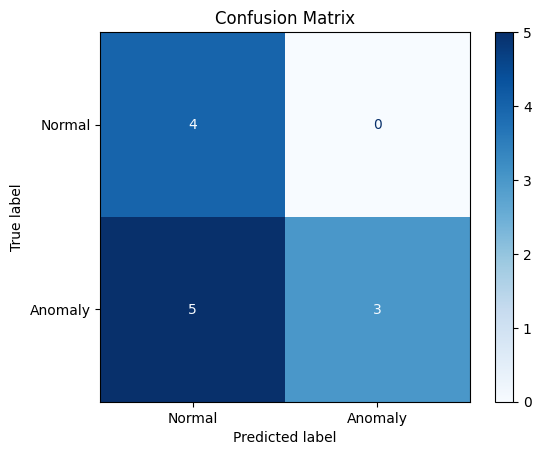

In [ ]:
dataset_root = Path("val/")
output_root = Path("val_out/")
output_root.mkdir(parents=True, exist_ok=True)

all_preds = []
all_actuals = []

fps = 10

for folder in sorted(dataset_root.iterdir()):
    if folder.is_dir():
        print(f"Processing folder: {folder.name}")
        ds = STUDataset(folder, single_scene=True)
        ds_iter = iter_ds(ds, window_size=50, step_size=20, video_output_path="output_video.mp4", fps=fps)
        
        preds = []
        actuals = []

        # ======== Video for each scene ============ 
        width, height = ds.image_width, ds.image_height
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
        video_writer = cv2.VideoWriter(output_root/f"{folder.name}_out.mp4", fourcc, fps, (width, height))
        # ================================================
        

        n_samples = (len(ds) - 50)/20 + 1
        for i, sample in enumerate(ds_iter):
            result = process_and_run()
            # print(result)
            anomaly = "Classification: Anomaly" in result
            actuals.append(sample[1])
            preds.append(anomaly)
            
            print(f"\tActual: {sample[1]}, Predicted: {anomaly} ---- [{i+1}/{n_samples}]")

            # Append images to video
            images = sample[2]
            for img in images:
                # Convert PIL Image to OpenCV format
                img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

                # Write prediction and actual on the image
                # Put text on rectangle background in the top-center
                # Make rectangle green if prediction is correct, red otherwise
                if anomaly == sample[1]:
                    rect_color = (0, 255, 0)  # Green
                else:
                    rect_color = (0, 0, 255)  # Red
                cv2.rectangle(img_cv, (width//2 - 400, 30), (width//2 + 400, 140), rect_color, -1)
                cv2.putText(
                    img_cv,
                    f"Predicted: {anomaly} | Actual: {sample[1]}",
                    (width//2 - 360, 100),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    (255, 255, 255),
                    3,
                )
                
                # put next text on a transparent black rectangle
                
                cv2.putText(img_cv, f"Sample Num: {i+1}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                video_writer.write(img_cv)
        video_writer.release()
        print(f"Processed video saved at {output_root/f'{folder.name}_out.mp4'}")
        

        all_preds.extend(preds)
        all_actuals.extend(actuals)
        compute_metrics(preds, actuals)
    break

print("Overall Metrics:")
compute_metrics(all_preds, all_actuals)
plot_confusion_matrix(all_preds, all_actuals)


In [48]:
!cp "val_out/125_out.mp4" /mnt/c/Users/adeju/Downloads/output_video.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 58.33%
Precision: 100.00%
Recall: 37.50%
F1-score: 54.55%
True Positives: 3
False Positives: 0
True Negatives: 4
False Negatives: 5


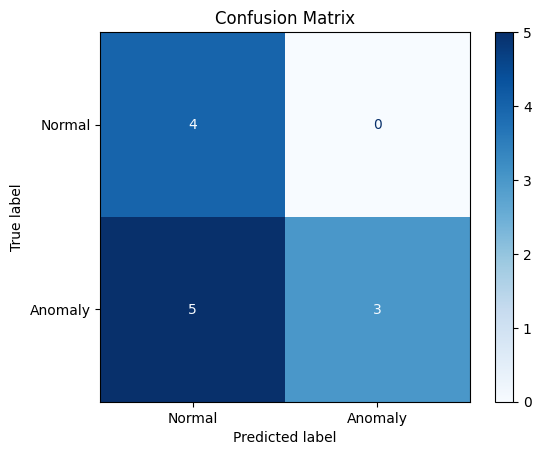

In [ ]:
# # Accuracy calculation
# correct = sum(p == a for p, a in zip(predictions, actuals))
# accuracy = correct / len(actuals) if actuals else 0
# print("="*30)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Computer precision, recall, F1-score
# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(actuals, predictions)
# recall = recall_score(actuals, predictions)
# f1 = f1_score(actuals, predictions)
# print("="*30)
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1 * 100:.2f}%")

# # True Positives, False Positives, True Negatives, False Negatives
# tp = sum((p == 1) and (a == 1) for p, a in zip(predictions, actuals))
# fp = sum((p == 1) and (a == 0) for p, a in zip(predictions, actuals))
# tn = sum((p == 0) and (a == 0) for p, a in zip(predictions, actuals))
# fn = sum((p == 0) and (a == 1) for p, a in zip(predictions, actuals))
# print("="*30)
# print(f"True Positives: {tp}")
# print(f"False Positives: {fp}")
# print(f"True Negatives: {tn}")
# print(f"False Negatives: {fn}")

# # Plot confusion matrix
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay
# cm = np.array([[tn, fp], [fn, tp]])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
"""
cp -r val/125/* cosmos_val/101/  || sudo mv val/126/* cosmos_val/101/

sudo mv cosmos_val/101/* val/126/

sudo rm -rf cosmos_val/101/*
"""

In [6]:
b = """“You are an autonomous driving safety and perception expert analyzing this video for potential EXTERNAL ANOMALIES that could affect the safe and predictable operation of an autonomous vehicle.

<think>
"CRITICAL ANOMALIES:\n"
- Unexpected obstacles on or near the roadway (debris, animals, fallen objects)
- Pedestrians or cyclists entering or approaching the vehicle’s path
- Vehicles violating traffic rules (red-light running, wrong-way driving, illegal turns)
- Close calls or near-collision situations involving any road user
- Road work zones, blocked lanes, or temporary cones
- Emergency vehicles or flashing lights impacting traffic flow
- Missing, obscured, or malfunctioning traffic signals/signs
- Road surface hazards (potholes, water puddles, ice, uneven terrain)
- Stopped or stalled vehicles obstructing lanes
- Unusual or unpredictable movement of surrounding objects or road users
"CONTEXT MISINTERPRETATION ANOMALIES:"
- Situations where the vehicle might misclassify or misinterpret visual cues
    (e.g., a person wearing clothing with a STOP sign print mistaken for a real traffic sign)
- False positives due to reflections, shadows, or advertisements resembling real road objects
- Unclear or deceptive visual context (e.g., temporary paint, digital displays, mirrored surfaces)
- Any environment where perception sensors might interpret context incorrectly and trigger false actions
"OTHER SAFETY CONCERNS:"
- Speeding or aggressive driving by surrounding vehicles
- Unsafe lane changes, tailgating, or sudden stops
- Faded or missing lane markings
- Poor visibility (fog, glare, heavy rain, low light)
- Overcrowded intersections or congested roadways
- Objects falling from moving vehicles (cargo, equipment)
- Environmental interference (smoke, dust, reflections)
- Any condition likely to reduce sensor or perception reliability
Analyze the video carefully and identify all external anomalies and context-related perception issues that could cause unsafe or unpredictable autonomous vehicle behavior.Focus especially on how environmental context could lead to false detection or unsafe reaction.
</think>
<answer>
Is there any external anomaly  in this video? 
</answer>”
"""

len(b.split())

308

In [7]:
c = """“I am the fault monitor for a vision-based autonomous vehicle. My job is to analyze the vehicle’s observations and identify anything that could cause the vehicle to take actions that are unsafe, unpredictable or violate traffic rules. For each object that the vehicle observes, I will reason about whether the object constitutes a normal observation or an anomaly. Normal observations do not detrimentally affect the vehicle’s performance, whereas anomalies might. Finally, I will classify whether the overall scene is normal or abnormal.

<think>
1. Is this common to see while driving?
2. Can this influence the vehicle’s behavior?
3. Can the vehicle drive safely in its presence?
4. Can this cause the vehicle to make unpredictable or unsafe maneuvers?
</think>

<answer>
Give your classification as 'Classification: Normal' or 'Classification: Anomaly'
</answer>”
"""

len(c.split())

131

In [ ]:
# 



def terminal_cost()

In [5]:
%cd ..

/home/daniel/Dev/ms_proj


/home/daniel/Dev/ms_proj/cosmos-reason1/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%cd ../../stu_dataset

/home/daniel/Dev/ms_proj/stu_dataset


/home/daniel/Dev/ms_proj/cosmos-reason1/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
!cp -r ./output_videos/ ~/Dev/cosmos_fp4_quantization/output_videos/

In [6]:
# Quick Test

from stu_video_dataset import stu_video_dataloader
# from stu_dataset.stu_video_dataset import stu_video_dataloader
from pathlib import Path

dataset_dir = "/home/daniel/Dev/ms_proj/stu_dataset/val"
# make output_videos directory if it does not exist
output_videos_dir = Path("./output_videos/")
output_videos_dir.mkdir(parents=True, exist_ok=True)
# http://127.0.0.1:8888/tree?token=b9141ba810aadad78f126e8260ed48bfe9adb7da040a8cdb

for video_file, _, _ in stu_video_dataloader(dataset_dir, window_size=50, step_size=20, fps=10, separate_videos=True, output_dir="./output_videos/"):
    video_path = str(Path(video_file).absolute())
    print(video_file)
    print("Processing video:", video_path)

Output videos will be saved to: /home/daniel/Dev/ms_proj/stu_dataset/output_videos
Processing folder: 125


/home/daniel/Dev/ms_proj/stu_dataset/stu_video_dataset.py:113: RuntimeWarning: invalid value encountered in cast
  pts_int = image_points.astype(int)


Writing video to output_videos/scene_125_30.mp4
output_videos/scene_125_30.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_30.mp4
output_videos/scene_125_30.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_30.mp4
Writing video to output_videos/scene_125_50.mp4
Writing video to output_videos/scene_125_50.mp4
output_videos/scene_125_50.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_50.mp4
output_videos/scene_125_50.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_50.mp4
Writing video to output_videos/scene_125_70.mp4
Writing video to output_videos/scene_125_70.mp4
output_videos/scene_125_70.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_70.mp4
output_videos/scene_125_70.mp4
Processing video: /home/daniel/Dev/ms_proj/stu_dataset/output_videos/scene_125_70.mp4
Writing video to output_videos/scene_125_90.mp4
Writing vi

In [16]:
import glob
import os
video_dir = "output_videos/"
video_files = glob.glob(os.path.join(video_dir, "*.mp4")) + \
                  glob.glob(os.path.join(video_dir, "*.mkv"))

In [2]:
# Varied prompts for calibration
base_prompts = [
    "Describe the events in this video in detail.\n",
    "What is happening in this scene?\n",
    "Explain the physics observed in this video.\n",
    "Is there any anomaly in this footage?\n",
    "List the objects visible in the video.\n",
    (
    "Is there any external anomaly in this video? Reply with exactly one word of the following:\n"
    "Classification: Anomaly — if any obstacle, obstruction, or unsafe condition is visible.\n"
    "Classification: Normal — if no anomaly or obstruction is visible.\n"
    )
]

base_text = (
    "You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.\n\n"
    "<think>\n"
    "- Obstacles, pedestrians, or vehicles violating rules\n"
    "- Roadwork, blocked lanes, poor visibility, or hazards\n"
    "- Reflections, shadows, or false visual cues confusing perception\n"
    "</think>\n\n"
    "<answer>\n"
    )

count = 0
# Lazy imports for video handling if needed by processor

while count < 10:            
        prompt_text = base_text + base_prompts[count % len(base_prompts)] + "</answer>"
        print(prompt_text)
        count += 1

You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.

<think>
- Obstacles, pedestrians, or vehicles violating rules
- Roadwork, blocked lanes, poor visibility, or hazards
- Reflections, shadows, or false visual cues confusing perception
</think>

<answer>
Describe the events in this video in detail.
</answer>
You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.

<think>
- Obstacles, pedestrians, or vehicles violating rules
- Roadwork, blocked lanes, poor visibility, or hazards
- Reflections, shadows, or false visual cues confusing perception
</think>

<answer>
What is happening in this scene?
</answer>
You are an autonomous driving safety expert analyzing this video for EXTERNAL ANOMALIES that may impact safe AV operation.

<think>
- Obstacles, pedestrians, or vehicles violating rules
- Roadwork, blocked lanes, poor visibility, or hazards
- Reflect